# ⚖ Income Inequality Prediction 💲💲💲⚖
The objective of this challenge is to create a machine learning model to predict whether an individual earns above or below a certain amount.

In [1]:
# Dependensies:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
import joblib
from sklearn.inspection import permutation_importance
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [2]:
# Load the data
df = pd.read_csv('../Dataset/data.csv')
print(df.shape)
df.sample(3)

(209499, 43)


,ID,age,gender,education,class,education_institute,marital_status,race,is_hispanic,employment_commitment,...,country_of_birth_mother,migration_code_change_in_msa,migration_prev_sunbelt,migration_code_move_within_reg,migration_code_change_in_reg,residence_1_year_ago,old_residence_reg,old_residence_state,importance_of_record,income_above_limit
208472,ID_TZ99066,65,Female,9th grade,NaN,NaN,Married-civilian spouse present,White,All other,Children or Armed Forces,...,US,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,1317.05,Below limit
48248,ID_TZ142565,59,Female,1st 2nd 3rd or 4th grade,Private,NaN,Married-A F spouse present,White,Mexican-American,Full-time schedules,...,Mexico,?,?,?,?,NaN,NaN,NaN,1518.99,Below limit
159273,ID_TZ5434,14,Male,Children,NaN,NaN,Never married,White,All other,Children or Armed Forces,...,US,?,?,?,?,NaN,NaN,NaN,1762.86,Below limit


#### Basic Look

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209499 entries, 0 to 209498
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              209499 non-null  object 
 1   age                             209499 non-null  int64  
 2   gender                          209499 non-null  object 
 3   education                       209499 non-null  object 
 4   class                           104254 non-null  object 
 5   education_institute             13302 non-null   object 
 6   marital_status                  209499 non-null  object 
 7   race                            209499 non-null  object 
 8   is_hispanic                     209499 non-null  object 
 9   employment_commitment           209499 non-null  object 
 10  unemployment_reason             6520 non-null    object 
 11  employment_stat                 209499 non-null  int64  
 12  wage_per_hour   

**Obs:::** 209499 Rows | 43 Columns | 1 Float | 12 Int | 30 Categorical | No timestamp | Target: income_above_limit (Above Limit / Below Limit) 
 

In [3]:
# Renaming Columns | Good Pratice :D
col_map = {col : col.lower().replace(' ', '_') for col in df.columns}
df.rename(columns=col_map, inplace=True)

In [4]:
df.columns

Index(['id', 'age', 'gender', 'education', 'class', 'education_institute',
       'marital_status', 'race', 'is_hispanic', 'employment_commitment',
       'unemployment_reason', 'employment_stat', 'wage_per_hour',
       'is_labor_union', 'working_week_per_year', 'industry_code',
       'industry_code_main', 'occupation_code', 'occupation_code_main',
       'total_employed', 'household_stat', 'household_summary',
       'under_18_family', 'veterans_admin_questionnaire', 'vet_benefit',
       'tax_status', 'gains', 'losses', 'stocks_status', 'citizenship',
       'mig_year', 'country_of_birth_own', 'country_of_birth_father',
       'country_of_birth_mother', 'migration_code_change_in_msa',
       'migration_prev_sunbelt', 'migration_code_move_within_reg',
       'migration_code_change_in_reg', 'residence_1_year_ago',
       'old_residence_reg', 'old_residence_state', 'importance_of_record',
       'income_above_limit'],
      dtype='object')

In [6]:
# Check for Duplicates
df.duplicated().sum()

0

In [7]:
# Check for constant columns
[col for col in df.columns if df[col].nunique() == 1]

[]

In [8]:
# Check for missing values
df.isnull().sum()

id                                     0
age                                    0
gender                                 0
education                              0
class                             105245
education_institute               196197
marital_status                         0
race                                   0
is_hispanic                            0
employment_commitment                  0
unemployment_reason               202979
employment_stat                        0
wage_per_hour                          0
is_labor_union                    189420
working_week_per_year                  0
industry_code                          0
industry_code_main                     0
occupation_code                        0
occupation_code_main              105694
total_employed                         0
household_stat                         0
household_summary                      0
under_18_family                   151654
veterans_admin_questionnaire      207415
vet_benefit     

In [9]:
df.describe().T # Numerical Features

,count,mean,std,min,25%,50%,75%,max
age,209499.0,34.518728,22.306738,0.00,15.00,33.00,50.00,90.0
employment_stat,209499.0,0.176760,0.555562,0.00,0.00,0.00,0.00,2.0
wage_per_hour,209499.0,55.433487,276.757327,0.00,0.00,0.00,0.00,9999.0
working_week_per_year,209499.0,23.158850,24.397963,0.00,0.00,8.00,52.00,52.0
industry_code,209499.0,15.332398,18.049655,0.00,0.00,0.00,33.00,51.0
occupation_code,209499.0,11.321734,14.460839,0.00,0.00,0.00,26.00,46.0
total_employed,209499.0,1.956067,2.365154,0.00,0.00,1.00,4.00,6.0
vet_benefit,209499.0,1.515854,0.850853,0.00,2.00,2.00,2.00,2.0
gains,209499.0,435.926887,4696.359500,0.00,0.00,0.00,0.00,99999.0
losses,209499.0,36.881737,270.383302,0.00,0.00,0.00,0.00,4608.0


In [10]:
df.describe(include='object').T # Categorical Features

,count,unique,top,freq
id,209499,209499,ID_TZ0000,1
gender,209499,2,Female,108784
education,209499,17,High school graduate,50627
class,104254,8,Private,75617
education_institute,13302,2,High school,7247
marital_status,209499,7,Never married,90723
race,209499,5,White,175709
is_hispanic,209499,10,All other,180404
employment_commitment,209499,8,Children or Armed Forces,129789
unemployment_reason,6520,5,Other job loser,2242


_Observations:_ <br>
>1.Most of the Employees have **Below Limit** Income.<br>
>2.Multicoliner columns might exist : (e.g) residence_1_year_ago , citizenship , migration *cols<br>
>3.Id column can be dropped : Inconsistent ids assigned / Irrelevant column to target var<br>
>4.Highly imbalanced cols exit : losses, gains, employment_stat, wage_per_hr,etc<br>
>5.Many Unemployed people are included and are by default fall under Below Limit Income<br>

---

<Axes: >

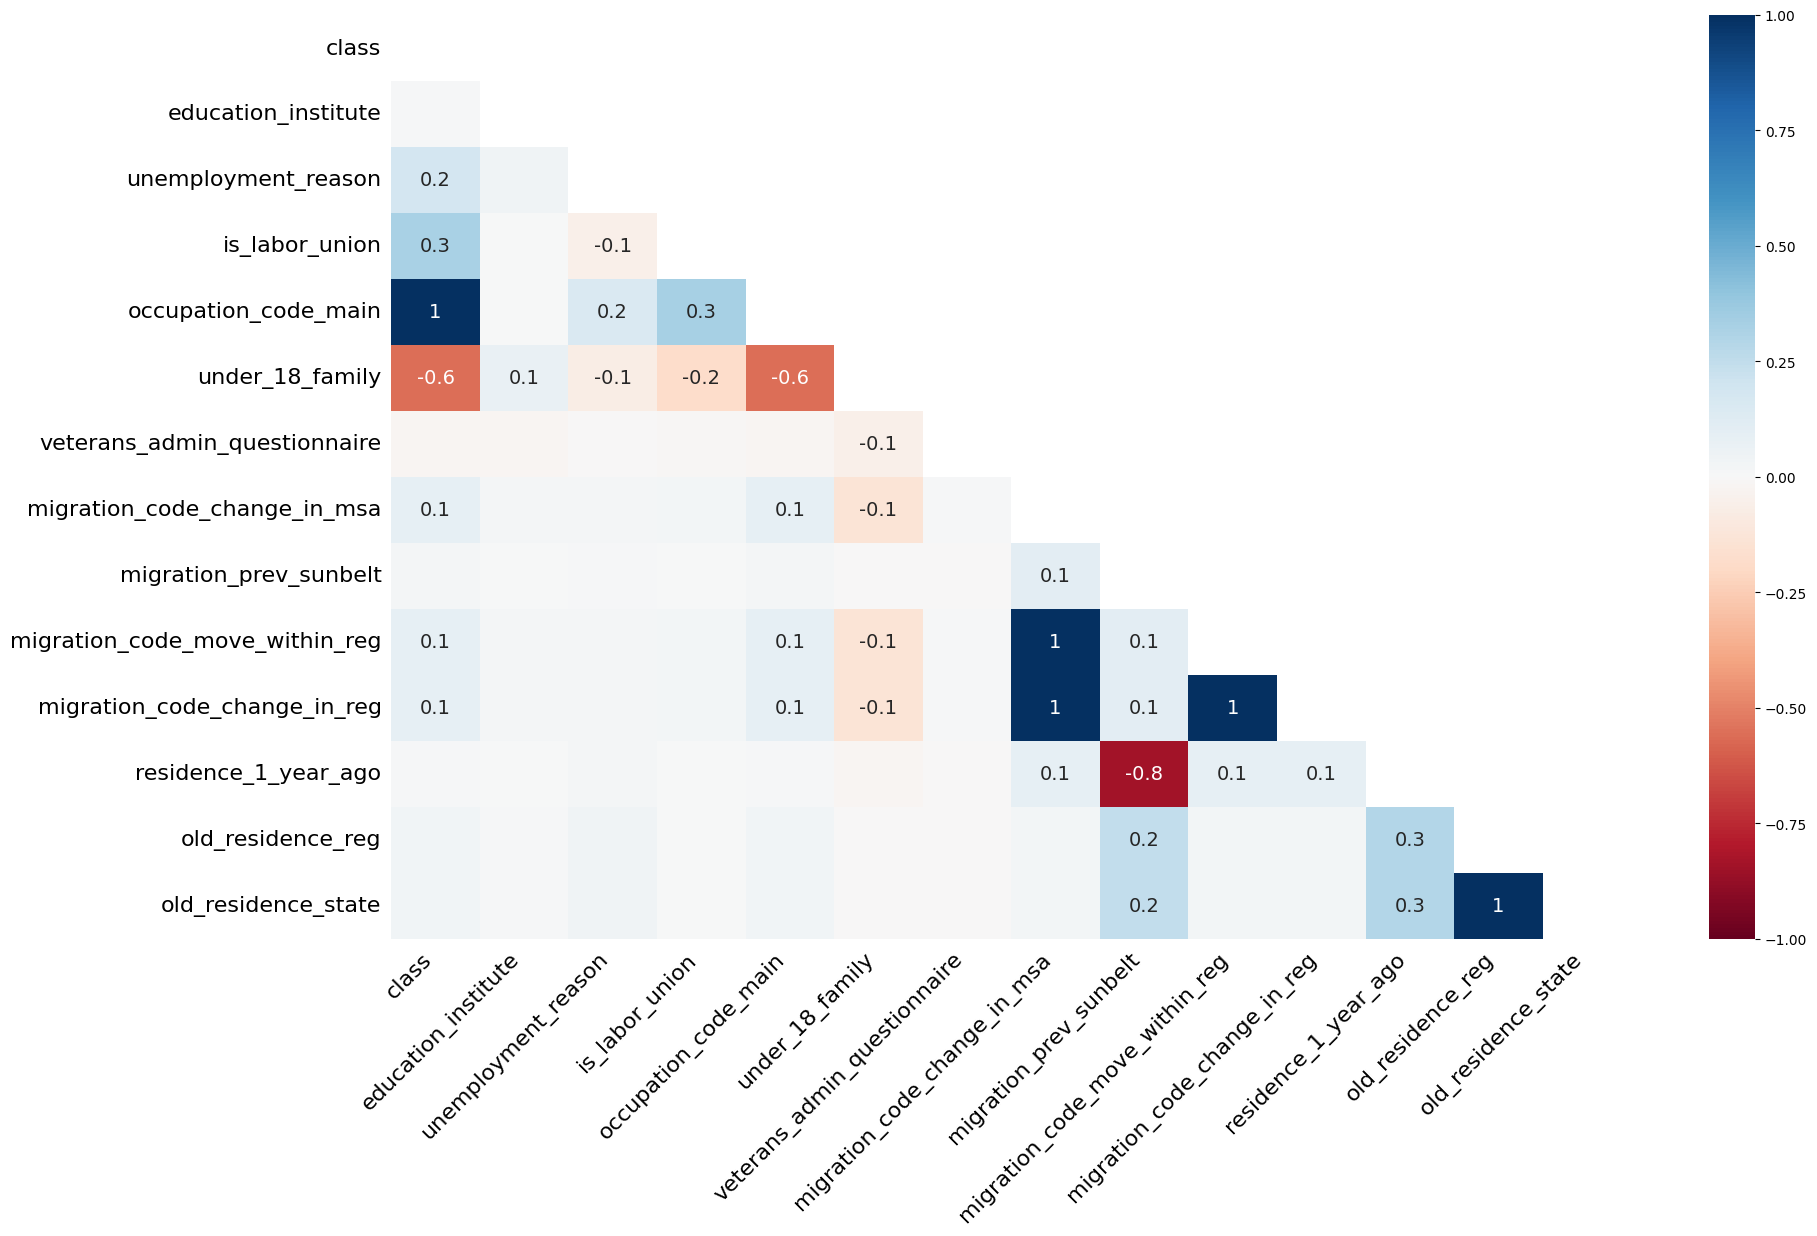

In [11]:
# Missing Vlaues Visualization
msno.heatmap(df)

Nullity correlation ranges from `-1` (if one variable appears the other definitely does not) to `0` (variables appearing or not appearing have no effect on one another) <br> to `1`(if one variable appears the other definitely also does).

<Axes: >

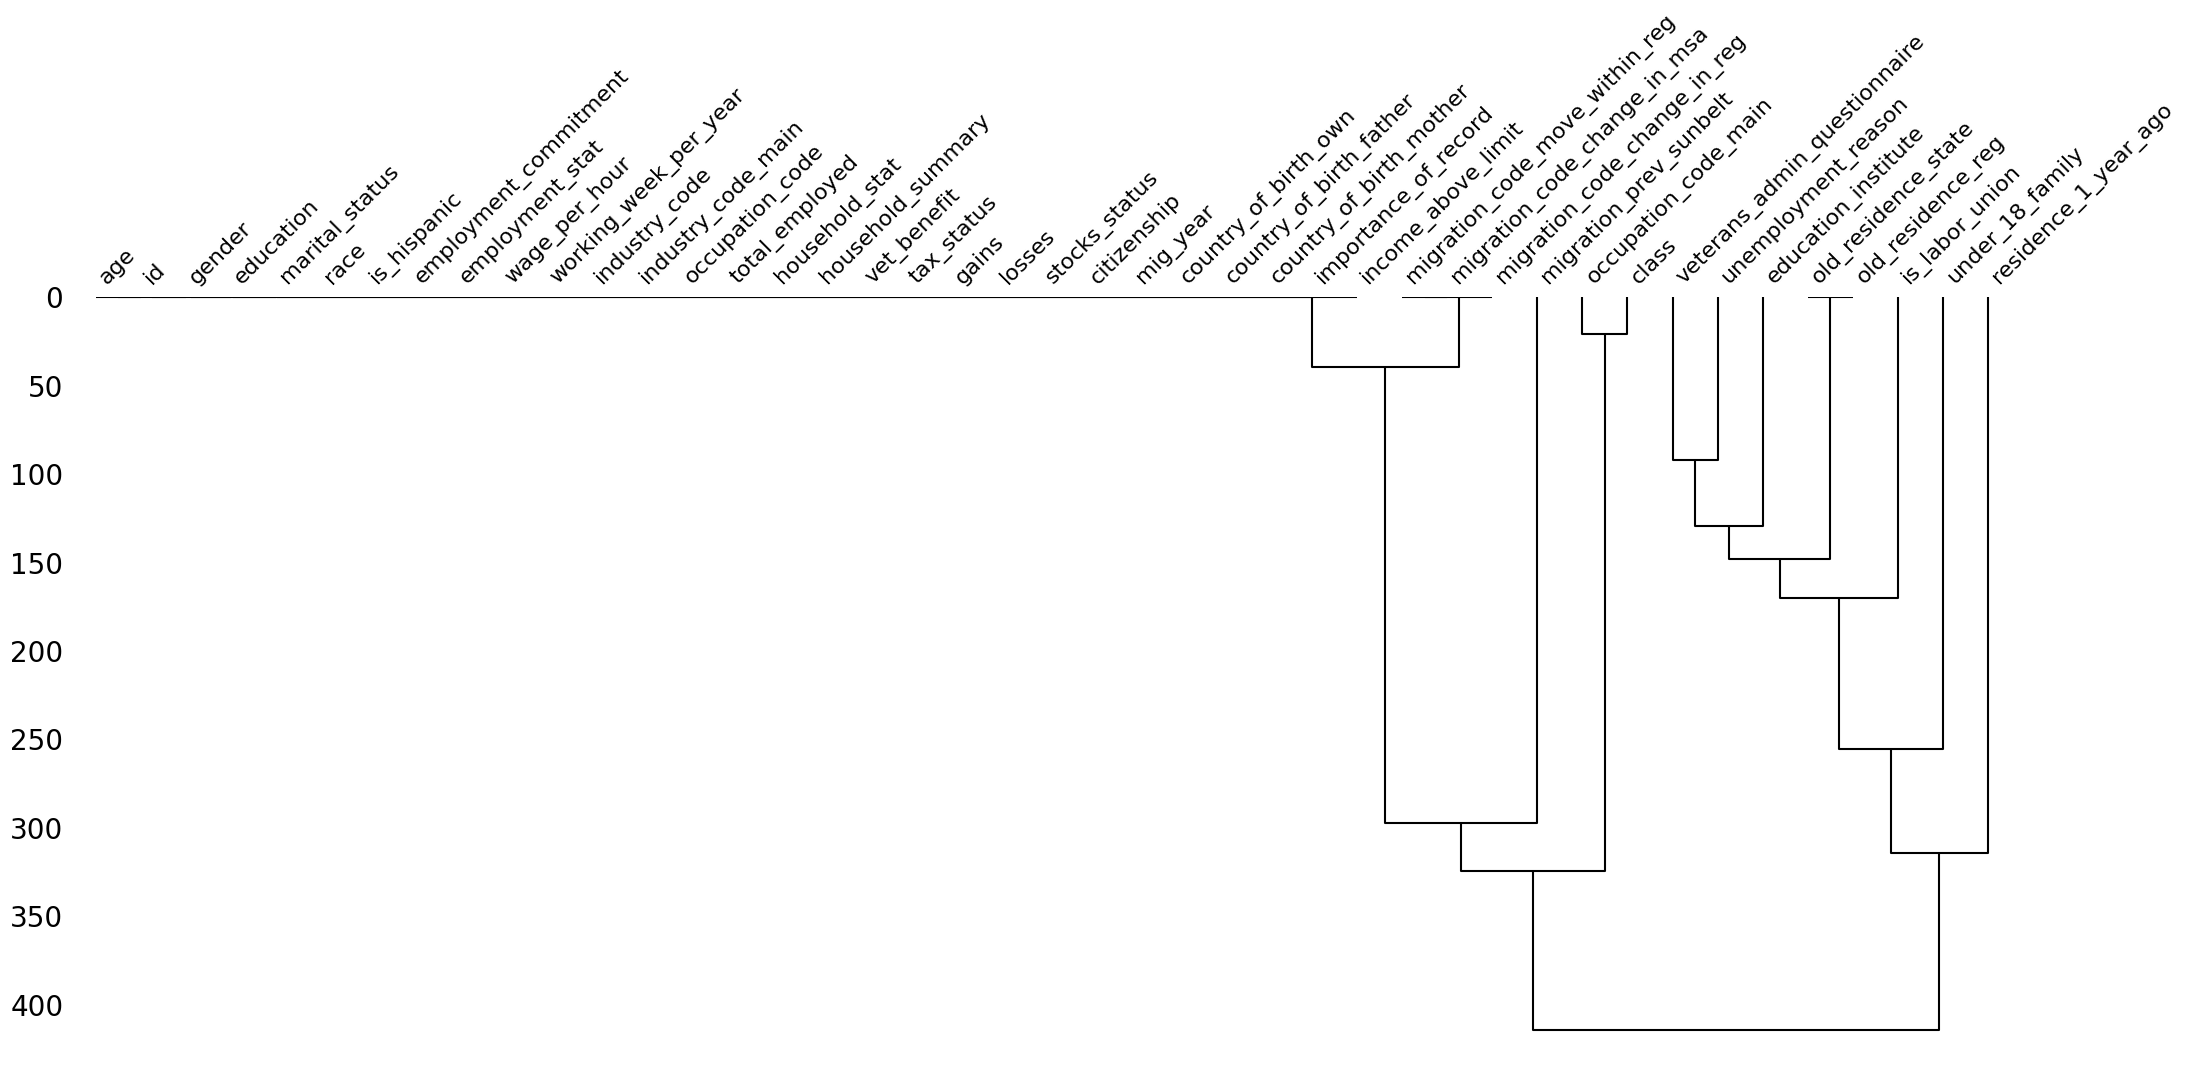

In [12]:
msno.dendrogram(df)

Nullity Correlation: <br>
To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example **the dendrogram glues together the variables which are required and therefore present in every record.** <br>
However we cannot select these features directly based on the this dendogram...

---

C:\Users\maxxk\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maxxk\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maxxk\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


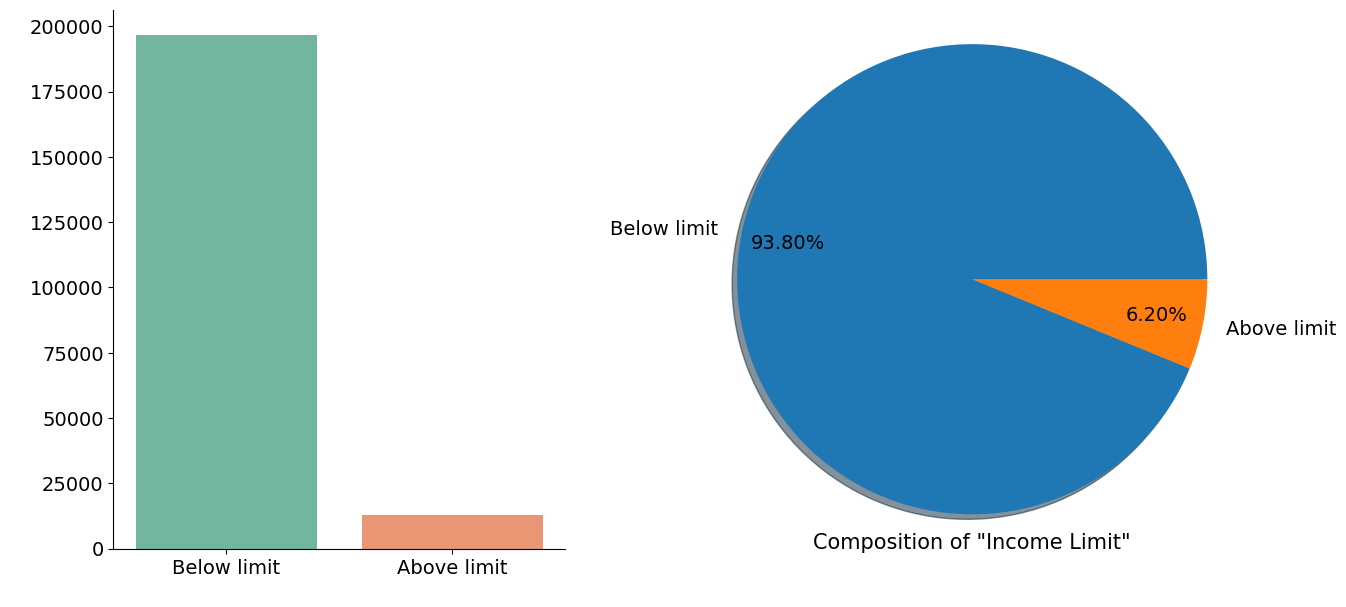

In [13]:
# Target Distribution (income_above_limit)

plt.figure(figsize=(14,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=df["income_above_limit"], palette="Set2")
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
# pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(df["income_above_limit"].value_counts(),
        labels=list(df["income_above_limit"].unique()),
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize':14}
       )
ax2.set_xlabel(" ")
plt.xlabel('Composition of "Income Limit"', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

_Cheers :D ! No need to create a model_ 😂... Target is highly biased towards Below Limit Income...<br>
> Resampling Techniques are required <br>
> Can we remove Redundant rows ?;::: its called Downsampling and adding weights to Downsampled Data <br>

***It's a Binary Classification Problem***

---

In [4]:
# Assigning actual dtype to each column
obj_cols = df.select_dtypes("object").columns
df[obj_cols] = df[obj_cols].astype("category")
df.dtypes

id                                category
age                                  int64
gender                            category
education                         category
class                             category
education_institute               category
marital_status                    category
race                              category
is_hispanic                       category
employment_commitment             category
unemployment_reason               category
employment_stat                      int64
wage_per_hour                        int64
is_labor_union                    category
working_week_per_year                int64
industry_code                        int64
industry_code_main                category
occupation_code                      int64
occupation_code_main              category
total_employed                       int64
household_stat                    category
household_summary                 category
under_18_family                   category
veterans_ad

---

### Missing Value Treatment <br>

DROP COLUMNS: with missing values > 50% <br>

In [5]:
missing_cols = df.columns[df.isnull().any()]


In [6]:
# Dropping columns ::: 50% or more missing values
cols_to_drop = list(df.columns[df.isnull().mean() > 0.5])
# drop columns 
df.drop(columns=["id"]+cols_to_drop, inplace=True) # Also Dropping ID column as it is not required
cols_to_drop

['class',
 'education_institute',
 'unemployment_reason',
 'is_labor_union',
 'occupation_code_main',
 'under_18_family',
 'veterans_admin_questionnaire',
 'residence_1_year_ago',
 'old_residence_reg',
 'old_residence_state']

In [7]:
def miss(df):
    missing_values = df.isna().sum()
    missing_values_percent = (missing_values / df.shape[0]) * 100
    missing_values_columns = pd.DataFrame({'column_name': df.columns, 'missing_values': missing_values, 'missing_values_percent': missing_values_percent})
    missing_values_columns = missing_values_columns.sort_values(by=['missing_values_percent'], ascending=False)
    missing_values_columns['data_type'] = df.dtypes
    return missing_values_columns

miss(df)

,column_name,missing_values,missing_values_percent,data_type
migration_prev_sunbelt,migration_prev_sunbelt,88452,42.220727,category
migration_code_change_in_reg,migration_code_change_in_reg,1588,0.757999,category
migration_code_move_within_reg,migration_code_move_within_reg,1588,0.757999,category
migration_code_change_in_msa,migration_code_change_in_msa,1588,0.757999,category
age,age,0,0.000000,int64
gender,gender,0,0.000000,category
importance_of_record,importance_of_record,0,0.000000,float64
country_of_birth_mother,country_of_birth_mother,0,0.000000,category
country_of_birth_father,country_of_birth_father,0,0.000000,category
country_of_birth_own,country_of_birth_own,0,0.000000,category


In [7]:
# migration_prev_sunbelt can also be dropped as 42% of the values are missing
df.drop(columns=['migration_prev_sunbelt'], inplace=True)

Simple Imputer: <br>

In [8]:
df_imputed = df.copy()
freq_imputer = SimpleImputer(strategy='most_frequent')
df_imputed.iloc[:, :] = freq_imputer.fit_transform(df_imputed)

In [10]:
miss(df_imputed)

,column_name,missing_values,missing_values_percent,data_type
age,age,0,0.0,int64
vet_benefit,vet_benefit,0,0.0,int64
importance_of_record,importance_of_record,0,0.0,float64
migration_code_change_in_reg,migration_code_change_in_reg,0,0.0,category
migration_code_move_within_reg,migration_code_move_within_reg,0,0.0,category
migration_code_change_in_msa,migration_code_change_in_msa,0,0.0,category
country_of_birth_mother,country_of_birth_mother,0,0.0,category
country_of_birth_father,country_of_birth_father,0,0.0,category
country_of_birth_own,country_of_birth_own,0,0.0,category
mig_year,mig_year,0,0.0,int64


In [ ]:
# Knn Imputer for missing values           CAN only be done on numerical data! :(
# imputer = KNNImputer(n_neighbors=5)
# imputer.fit(df)
# df_imputed = imputer.transform(df)

---

### Splitting Data 

In [9]:
df_imputed.shape

(209499, 31)

In [10]:
X = df_imputed.drop(columns=['income_above_limit'], axis=1)
y = df_imputed['income_above_limit']
# Spliting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 


((167599, 30), (41900, 30), (167599,), (41900,))

In [13]:
X_train = X_train[inp_feat] # For Post Feature Selection Run...
X_test = X_test[inp_feat]

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 


((167599, 12), (41900, 12), (167599,), (41900,))

---

### Encoding Categorical Variables <br>

In [10]:
df_imputed.select_dtypes(include='category').nunique() # Filter For Categorical Columns

gender                             2
education                         17
marital_status                     7
race                               5
is_hispanic                       10
employment_commitment              8
industry_code_main                24
household_stat                    38
household_summary                  8
tax_status                         6
citizenship                        5
country_of_birth_own              43
country_of_birth_father           43
country_of_birth_mother           43
migration_code_change_in_msa       9
migration_code_move_within_reg     9
migration_code_change_in_reg       8
income_above_limit                 2
dtype: int64

Obs and Plan: <br>
>Features with <= 9 unique values : Label Encoding <br>
>Features with > 9 unique values : Target Encoding <br>

>Also Learned that : High dimensionality can be handled by Algoritms like Random Forest, XGBoost, etc <br>
>Low dimensionality can be handled by Algoritms like Logistic Regression, SVM, etc <br>
>SO, `One Hot Encoding` ::: Good choice for `Logistic Regression` <br>
>`Target Encoding` many other available ::: Good choice for `Random Forest, XGBoost`, etc <br>

In [14]:
df_imputed.sample(3)

,age,gender,education,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,...,citizenship,mig_year,country_of_birth_own,country_of_birth_father,country_of_birth_mother,migration_code_change_in_msa,migration_code_move_within_reg,migration_code_change_in_reg,importance_of_record,income_above_limit
54134,14,Female,Children,Never married,White,All other,Children or Armed Forces,0,0,0,...,Native,94,US,US,US,unchanged,unchanged,unchanged,1344.64,Below limit
205740,38,Female,Some college but no degree,Married-civilian spouse present,White,Central or South American,Children or Armed Forces,0,0,52,...,Foreign born- Not a citizen of U S,94,Honduras,Honduras,Honduras,unchanged,unchanged,unchanged,1747.88,Below limit
5724,28,Female,Some college but no degree,Married-civilian spouse present,White,All other,Children or Armed Forces,2,0,20,...,Native,94,US,US,US,unchanged,unchanged,unchanged,509.77,Below limit


We will be doing Target Encoding for all the features with > 9 unique values <br>
and Label Encoding for all the features with <= 9 unique values <br>

In [15]:
X_train.dtypes

age                         int64
working_week_per_year       int64
gains                       int64
education                category
gender                   category
occupation_code             int64
stocks_status               int64
industry_code_main       category
total_employed              int64
tax_status               category
household_stat           category
losses                      int64
dtype: object

In [15]:
# Assigning actual dtype to each column
obj_cols = X_train.select_dtypes("object").columns
X_train[obj_cols] = X_train[obj_cols].astype("category")
X_test[obj_cols] = X_test[obj_cols].astype("category")

In [16]:
# Need to seperate label encoded columns and target encoded columns
def ordinal_encoder(split):
    req_list = []
    for i in split[split.select_dtypes(include='category').columns]:
        if split[i].nunique() <= 9:
            req_list.append(i)
    oe = OrdinalEncoder()
    split[req_list] = oe.fit_transform(split[req_list])
    joblib.dump(oe, '../Model/ordinal_encoder.joblib')
    return split[req_list]

In [17]:
# Now the target Encoder
def target_encoder(split,enc_y):
    req_list = []
    for i in split[split.select_dtypes(include='category').columns]:
        if split[i].nunique() > 9:
            req_list.append(i)
    target_enc = TargetEncoder()
    target_enc_df = target_enc.fit_transform(split[req_list],enc_y)
    joblib.dump(target_enc, '../Model/target_encoder.joblib')
    return target_enc_df

In [18]:
# Hard Coded Label Encoding ...
y_train_enc = y_train.replace({'Above limit': 1, 'Below limit':0})
y_test_enc = y_test.replace({'Above limit': 1, 'Below limit':0})
y_train_enc = y_train_enc.astype('int') # Converting to int type
y_test_enc = y_test_enc.astype('int')

In [19]:
num_feats = ['age', 'working_week_per_year', 'gains', 'occupation_code',
       'stocks_status', 'total_employed', 'losses']

# Encoding Splits
X_train_enc = pd.concat([X_train[num_feats],ordinal_encoder(X_train),target_encoder(X_train,y_train_enc)], axis=1)
X_test_enc = pd.concat([X_test[num_feats],ordinal_encoder(X_test),target_encoder(X_test,y_test_enc)], axis=1)

In [23]:
X_train.sample(5,random_state=1234)

,age,working_week_per_year,gains,education,gender,occupation_code,stocks_status,industry_code_main,total_employed,tax_status,household_stat,losses
50039,22,12,0,Associates degree-occup /vocational,1.0,0,0,Not in universe or children,5,5.0,Child 18+ never marr Not in a subfamily,0
37080,34,10,7298,High school graduate,0.0,32,0,Education,3,2.0,Householder,0
184732,35,52,0,Masters degree(MA MS MEng MEd MSW MBA),0.0,10,0,Education,6,2.0,Spouse of householder,0
165162,3,0,0,Children,0.0,0,0,Not in universe or children,0,4.0,Child <18 never marr not in subfamily,0
15169,11,0,0,Children,0.0,0,0,Not in universe or children,0,4.0,Child <18 never marr not in subfamily,0


In [22]:
X_train_enc.sample(5,random_state=1234)

,age,working_week_per_year,gains,occupation_code,stocks_status,total_employed,losses,gender,tax_status,education,industry_code_main,household_stat
50039,22,12,0,0,0,5,0,1.0,5.0,0.073640,0.008855,0.006882
37080,34,10,7298,32,0,3,0,0.0,2.0,0.039038,0.110730,0.147071
184732,35,52,0,10,0,6,0,0.0,2.0,0.317628,0.110730,0.054743
165162,3,0,0,0,0,0,0,0.0,4.0,0.000000,0.008855,0.000000
15169,11,0,0,0,0,0,0,0.0,4.0,0.000000,0.008855,0.000000


In [20]:
X_train_enc.shape, X_test_enc.shape, y_train_enc.shape, y_test_enc.shape

((167599, 12), (41900, 12), (167599,), (41900,))

---

#### Scaling Features : Robust Scaling (for outliers) <br>

In [21]:
def scale_features(x):
    scaler = RobustScaler()
    x_scaled = scaler.fit_transform(x)
    joblib.dump(scaler, '../Model/scaler.joblib')
    return x_scaled

In [22]:
X_train_enc[[col for col in X_train_enc.columns]] = scale_features(X_train_enc[[col for col in X_train_enc.columns]])
X_train_enc.sample(5)

,age,working_week_per_year,gains,occupation_code,stocks_status,total_employed,losses,gender,tax_status,education,industry_code_main,household_stat
129181,1.228571,-0.153846,0.0,0.000000,0.0,-0.25,0.0,1.0,-1.5,0.000000,0.000000,0.627779
72401,0.028571,0.846154,0.0,0.076923,0.0,0.75,0.0,1.0,-1.0,0.424756,1.089380,0.627779
119519,0.400000,0.846154,0.0,1.307692,0.0,0.50,0.0,1.0,-1.0,0.000000,2.114949,0.000000
73163,-0.285714,0.115385,0.0,0.000000,0.0,1.25,0.0,1.0,0.5,0.424756,0.000000,-0.325430
105981,-0.400000,0.769231,0.0,0.000000,0.0,1.00,0.0,0.0,-1.0,-0.549058,0.000000,0.000000


In [23]:
X_test_enc[[col for col in X_test_enc.columns]] = scale_features(X_test_enc[[col for col in X_test_enc.columns]])
X_test_enc.sample(5)

,age,working_week_per_year,gains,occupation_code,stocks_status,total_employed,losses,gender,tax_status,education,industry_code_main,household_stat
160086,-0.147059,-0.173077,0.0,0.000000,0.0,-0.25,0.0,0.0,0.0,-0.527517,0.000000,-0.236355
168100,0.235294,0.826923,0.0,0.615385,0.0,0.25,0.0,0.0,0.5,2.784455,0.354936,0.146419
11591,0.264706,0.596154,0.0,1.000000,0.0,1.25,0.0,0.0,0.5,2.784455,1.588638,-0.332359
188424,0.500000,0.826923,0.0,1.269231,0.0,0.25,0.0,1.0,-1.0,0.000000,0.933972,0.619598
70656,0.029412,0.826923,0.0,1.307692,0.0,0.75,0.0,1.0,-1.0,0.000000,1.499663,0.619598


---

#### Checking MiltiCollinearity and its Treatment
1. Corelation Matrix <br>
2. VIF (Variance Inflation Factor) <br>

In [82]:
#plot color scaled correlation matrix # [df_enc.select_dtypes(include="int64").columns]
X_train_enc['target'] = y_train_enc
corr=X_train_enc.corr()
corr = corr.style.background_gradient(cmap='coolwarm')
display(corr)

,age,gender,education,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,industry_code,industry_code_main,occupation_code,total_employed,household_stat,household_summary,vet_benefit,tax_status,gains,losses,stocks_status,citizenship,mig_year,country_of_birth_own,country_of_birth_father,country_of_birth_mother,migration_code_change_in_msa,migration_code_move_within_reg,migration_code_change_in_reg,importance_of_record,target
age,1.000000,-0.052202,-0.270010,-0.294514,0.082527,-0.120515,0.220559,-0.001477,0.034928,0.202374,0.156628,-0.177007,0.115255,0.138209,-0.599631,0.480496,0.674689,-0.313680,0.054723,0.061806,0.105470,-0.053263,0.004337,-0.032042,-0.139488,-0.121297,0.046632,0.033152,0.033592,0.000710,-0.136155
gender,-0.052202,1.000000,-0.042847,-0.041118,0.014168,0.001733,-0.026487,0.036354,0.020059,0.111082,-0.025193,-0.110124,0.139783,0.055493,-0.179282,-0.242815,-0.038530,0.046913,0.054833,0.064956,0.012763,0.001161,0.000785,-0.002417,0.001809,0.000840,-0.004403,-0.003872,-0.003996,0.031874,-0.156893
education,-0.270010,-0.042847,1.000000,0.251643,-0.042871,0.128749,-0.083239,-0.135607,-0.034808,-0.382875,-0.406631,0.390761,-0.050783,-0.331381,0.328495,-0.221700,-0.364221,0.197828,-0.152004,-0.101970,-0.119988,0.020226,-0.010564,0.129027,0.145867,0.139455,0.002981,0.004915,0.004343,-0.023603,0.391265
marital_status,-0.294514,-0.041118,0.251643,1.000000,-0.073089,0.048165,-0.100532,-0.089505,-0.078047,-0.394423,-0.312536,0.342468,-0.261842,-0.305557,0.444033,-0.433521,-0.390770,0.510438,-0.050063,-0.044094,-0.026776,0.030964,-0.005133,0.011008,0.045497,0.045054,-0.008874,-0.007129,-0.006993,-0.002786,0.149763
race,0.082527,0.014168,-0.042871,-0.073089,1.000000,0.073453,-0.004655,0.035544,0.007250,0.060696,0.025543,-0.047156,0.024572,0.016056,-0.053777,0.041649,0.053897,-0.045346,0.014879,0.020503,0.025927,0.149624,-0.017161,0.081271,0.040804,0.029686,0.028737,0.022628,0.022386,-0.025992,-0.044538
is_hispanic,-0.120515,0.001733,0.128749,0.048165,0.073453,1.000000,-0.005076,-0.042593,-0.032413,-0.056687,-0.058267,0.061323,0.024751,-0.052453,0.063814,-0.024807,-0.060100,0.030880,-0.022761,-0.023089,-0.033795,-0.394072,0.002046,0.453743,0.639941,0.618597,-0.016691,-0.006198,-0.006985,-0.136406,0.068060
employment_commitment,0.220559,-0.026487,-0.083239,-0.100532,-0.004655,-0.005076,1.000000,0.051073,0.010318,0.080473,0.104776,-0.094724,0.130620,0.104284,-0.163730,0.122623,0.317959,-0.077006,0.011458,0.012961,0.019995,-0.047836,0.575450,0.015822,-0.009555,-0.008087,-0.540294,-0.552694,-0.553637,0.024172,-0.017848
employment_stat,-0.001477,0.036354,-0.135607,-0.089505,0.035544,-0.042593,0.051073,1.000000,0.054699,0.268072,0.255038,-0.206820,0.228786,0.241733,-0.109587,0.028228,0.177249,-0.029127,0.016057,0.025245,-0.003063,0.029177,0.008912,-0.016423,-0.028662,-0.028519,-0.022376,-0.018083,-0.018268,0.014766,-0.043905
wage_per_hour,0.034928,0.020059,-0.034808,-0.078047,0.007250,-0.032413,0.010318,0.054699,1.000000,0.193746,0.162661,-0.177160,0.192950,0.190094,-0.088577,0.048336,0.111373,-0.057734,0.005324,0.013406,-0.006231,0.009063,0.001800,-0.014561,-0.021254,-0.022816,0.001762,0.001441,0.001642,0.013606,-0.023636
working_week_per_year,0.202374,0.111082,-0.382875,-0.394423,0.060696,-0.056687,0.080473,0.268072,0.193746,1.000000,0.754307,-0.741707,0.656703,0.746943,-0.447677,0.256174,0.530720,-0.283061,0.083886,0.099316,0.017050,-0.035813,0.009211,-0.008510,-0.042737,-0.044097,-0.000288,0.002591,0.002734,0.031334,-0.262773


In [84]:
X_train_enc.drop(columns=['target'], inplace=True)

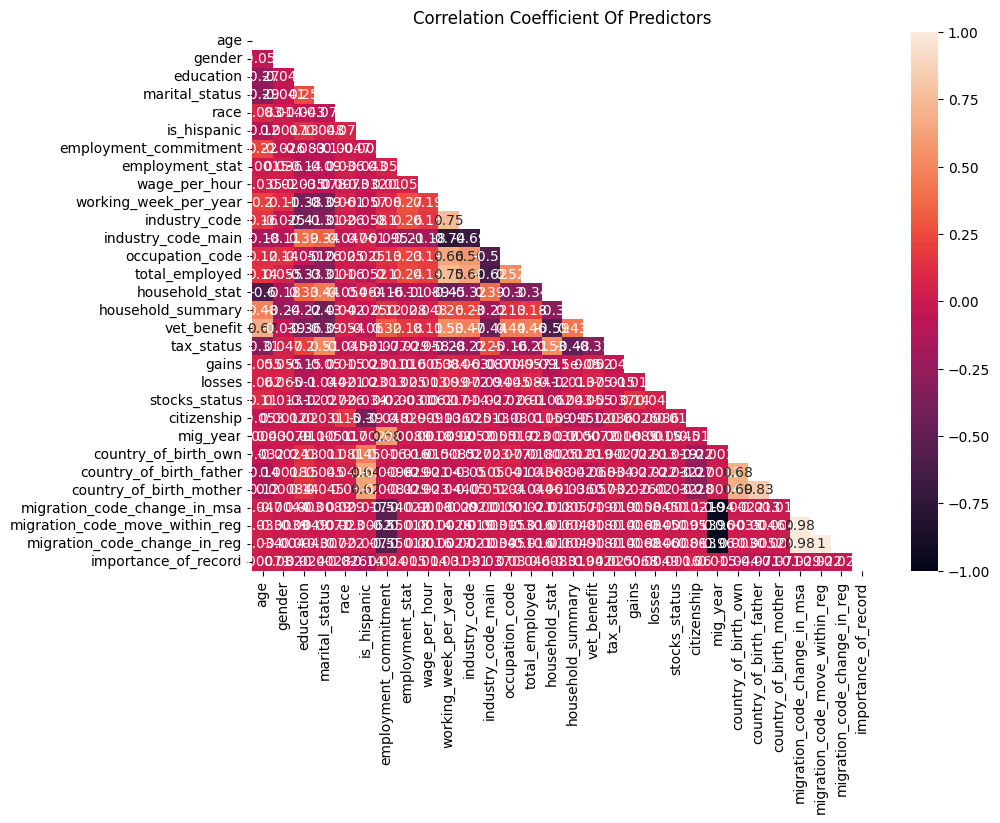

In [81]:
#Plot color scaled correlation matrix for ""numerical"" features

# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(X_train_enc.corr(), dtype=bool))

# generate heatmap
sns.heatmap(X_train_enc.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()


In [85]:
# Helper Function to get VIF ..... Needs Numeric features only :(
def compute_vif(considered_features,df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif


In [86]:
compute_vif(X_train_enc.columns,X_train_enc)

,Variable,VIF
0,age,2.909661
1,gender,1.246332
2,education,1.578380
3,marital_status,1.629712
4,race,1.080281
5,is_hispanic,2.006418
6,employment_commitment,1.808147
7,employment_stat,1.116397
8,wage_per_hour,1.055527
9,working_week_per_year,4.525796


Obs ::: keeping the threshold 10 for vif<br> 
we can see that <migration_code_change_in_msa> and <migration_code_change_in_reg> are highly correlated <br>
we will drop them...

In [20]:
X_train_enc.drop(columns=['migration_code_change_in_msa','migration_code_move_within_reg','migration_code_change_in_reg'], inplace=True)
X_test_enc.drop(columns=['migration_code_change_in_msa','migration_code_move_within_reg','migration_code_change_in_reg'], inplace=True)

In [88]:
# Recalculating VIF
compute_vif(X_train_enc.columns,X_train_enc)

,Variable,VIF
0,age,2.861240
1,gender,1.246186
2,education,1.577972
3,marital_status,1.629481
4,race,1.079552
5,is_hispanic,2.005016
6,employment_commitment,1.805611
7,employment_stat,1.114626
8,wage_per_hour,1.055472
9,working_week_per_year,4.522862


all featues are now under acceptable range of vif <br>

---

### Imbalance Treatment : SMOTETomek Sampaling Technique <br>

In [24]:
smt = SMOTETomek(random_state=42)
X_train, y_train = smt.fit_resample(X_train_enc, y_train_enc)
X_test, y_test = smt.fit_resample(X_test_enc, y_test_enc)

In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((312384, 12), (312384,), (78044, 12), (78044,))

In [26]:
counter = Counter(y_train)
for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

Class= 0, n=156192 (50.00%)
Class= 1, n=156192 (50.00%)


### Model Building <br>

In [25]:
def modeling(X, y, xtest, ytest):
    # Create a new training set by selecting the first half of the rows from the original training set
    new_X_train = X[:X.shape[0] // 2]
    new_y_train = y[:y.shape[0] // 2]
    
    new_X_test = xtest[:xtest.shape[0] // 2]
    new_y_test = ytest[:ytest.shape[0] // 2]
    # Above will reduce load on the training process
    
    # Initialize classifier models
    models = {
        "XGBoost": XGBClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Logistic Regression": LogisticRegression(),
        "SVM": SVC()
    }
    
    f1_scores = {}
    
    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(new_X_train, new_y_train)
        y_pred = model.predict(new_X_test)
        f1 = f1_score(new_y_test, y_pred)
        f1_scores[model_name] = f1
    
    return f1_scores


In [26]:
f1_scores = modeling(X_train, y_train, X_test, y_test)
print(f1_scores)

{'XGBoost': 0.9785114174924601, 'Random Forest': 0.9776780917588912, 'Logistic Regression': 0.9618788935284659, 'SVM': 0.9718683651804672}


Slicing Works !!!!!!!!!!!!!!!!!!!! XGboost it is ...

In [28]:
# Create an XGB classifier object
model = XGBClassifier()
new_X_train = X_train[:X_train.shape[0] // 2]
new_y_train = y_train[:y_train.shape[0] // 2]

new_X_test = X_test[:X_test.shape[0] // 2]
new_y_test = y_test[:y_test.shape[0] // 2]

model.fit(new_X_train, new_y_train)

y_pred = model.predict(new_X_test)

f1 = f1_score(new_y_test, y_pred)

print(f1)

0.9785114174924601


In [30]:
joblib.dump(model, 'xgboostv1.joblib')

['xgboostv1.joblib']

### Feature Selection <br>

In [ ]:
model = joblib.load('xgboostv1.joblib')

In [35]:
# Calculate permutation importance for the model
importance = permutation_importance(model, new_X_test, new_y_test)


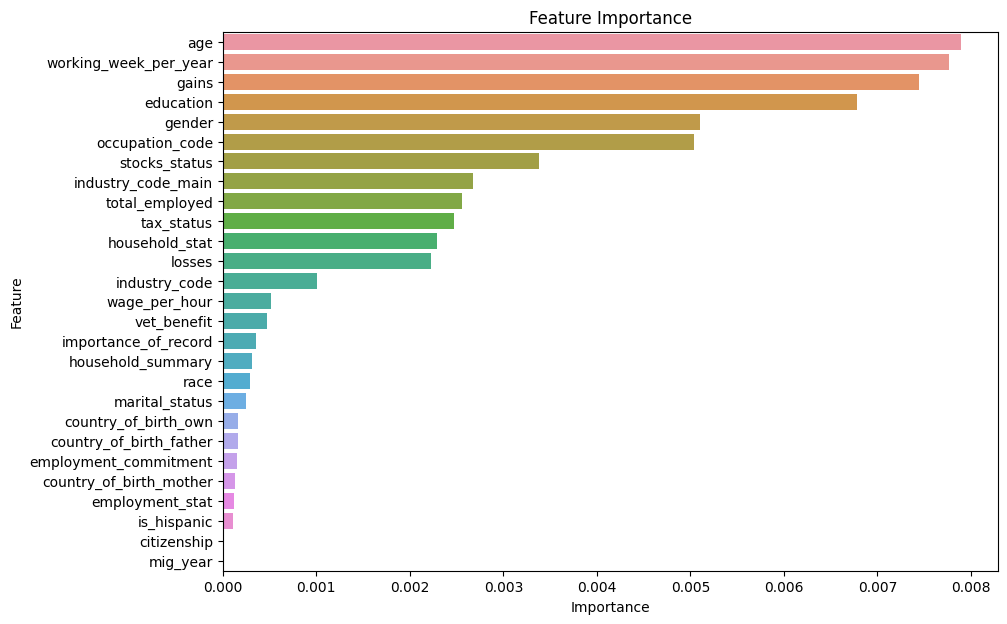

In [44]:
# Get list of feature names from new_X_train and add to dataframe with respective importance scores
feature_names = new_X_train.columns.tolist()
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance.importances_mean})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot a bar graph of feature importance
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()


In [46]:
feature_importance

,Feature,Importance
0,age,0.007892
9,working_week_per_year,0.007769
18,gains,0.007447
2,education,0.006782
1,gender,0.005099
12,occupation_code,0.005043
20,stocks_status,0.003386
11,industry_code_main,0.002680
13,total_employed,0.002562
17,tax_status,0.002470


Selecting Top 12 Features <br>

In [29]:
# Top 14 features
top12 = feature_importance['Feature'][:12].tolist()
top12

NameError: name 'feature_importance' is not defined

In [30]:
top12 = ['age',
 'working_week_per_year',
 'gains',
 'education',
 'gender',
 'occupation_code',
 'stocks_status',
 'industry_code_main',
 'total_employed',
 'tax_status',
 'household_stat',
 'losses']

In [31]:
# Remove all but the top 14 features from the training and test sets
X_train = X_train[top12]
X_test = X_test[top12]
X_train.shape, X_test.shape

((313326, 12), (78206, 12))

In [32]:
y_train.shape, y_test.shape

((313326,), (78206,))

In [28]:
X_train.sample(3)

,age,working_week_per_year,gains,education,gender,occupation_code,stocks_status,industry_code_main,total_employed,tax_status,household_stat,losses
160431,-0.571429,-0.153846,0.0,0.696835,1.0,0.000000,0.0,0.000000,-0.25,0.0,0.372221,0.0
16117,0.914286,-0.153846,0.0,0.000000,1.0,0.000000,0.0,0.000000,-0.25,-0.5,-0.627779,0.0
146940,-0.171429,0.615385,0.0,0.543159,1.0,1.692308,0.0,-0.502027,0.50,0.5,0.325430,0.0


### Model Tuning <br>

In [53]:
# Objective function for Optuna optimization...

def objective(trial):
    # Define the hyperparameters to search
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
    'max_depth': trial.suggest_int('max_depth', 3, 15),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
    'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
    'gamma': trial.suggest_loguniform('gamma', 0.001, 10.0),  # Regularization parameter
    'alpha': trial.suggest_loguniform('alpha', 0.001, 10.0),  # Regularization parameter
    'lambda': trial.suggest_loguniform('lambda', 0.001, 10.0),  # Regularization parameter
}

    # Initialize k-fold cross-validation
    # kf = KFold(n_splits=10, shuffle=True, random_state=42)
    # Trying Stratified KFold
    stratified_kfold = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)

    # Initialize a list to store F1 scores
    f1_scores = []
    
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Initialize and train the XGBoost classifier with the current hyperparameters
        model = XGBClassifier(**params)
        
        # Create an evaluation set for early stopping
        eval_set = [(X_val_fold, y_val_fold)]

        # Train the model with early stopping
        model.fit(
            X_train_fold, 
            y_train_fold, 
            eval_set=eval_set, 
            early_stopping_rounds=10,  # You can adjust this value
            verbose=False
        )
        # Make predictions on the validation set
        y_pred = model.predict(X_val_fold)

        # Calculate the F1 score for this fold
        f1 = f1_score(y_val_fold, y_pred)
        f1_scores.append(f1)

    # Calculate the mean F1 score across all folds
    mean_f1 = sum(f1_scores) / len(f1_scores)

    return mean_f1

#### Primary Run 

In [37]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')  # Change direction to 'maximize' for F1 score
study.optimize(objective, n_trials=100)  # You can adjust the number of trials as needed

[I 2023-09-19 14:04:11,997] A new study created in memory with name: no-name-fbae7fcf-d61d-45ec-be73-db1f57b7d0d1
[I 2023-09-19 14:05:49,864] Trial 0 finished with value: 0.9477408631030212 and parameters: {'n_estimators': 822, 'max_depth': 9, 'learning_rate': 0.003737046355072141, 'subsample': 0.7488829756250546, 'colsample_bytree': 0.6292403808224707}. Best is trial 0 with value: 0.9477408631030212.
[I 2023-09-19 14:06:07,444] Trial 1 finished with value: 0.8909059918567681 and parameters: {'n_estimators': 204, 'max_depth': 4, 'learning_rate': 0.002249307806733761, 'subsample': 0.7263240961902916, 'colsample_bytree': 0.5456709805864542}. Best is trial 0 with value: 0.9477408631030212.
[I 2023-09-19 14:06:33,550] Trial 2 finished with value: 0.9485084543563496 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.030198187618473357, 'subsample': 0.2602161615635652, 'colsample_bytree': 0.38704636490473854}. Best is trial 2 with value: 0.9485084543563496.
[I 2023-09-1

KeyboardInterrupt: 

You can call above `KeyboardInterrupt` as `Early Stopping` <br>

#### Run 2 :
Adjusted the params , introduced regularization and introducd   `early_stopping_rounds=10` <br>

In [45]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')  # Change direction to 'maximize' for F1 score
study.optimize(objective, n_trials=50)  # You can adjust the number of trials as needed

[I 2023-09-19 15:22:12,612] A new study created in memory with name: no-name-0fd10b1a-2262-4517-9f7c-b5b48f4410bf
[I 2023-09-19 15:22:37,755] Trial 0 finished with value: 0.9709937103687329 and parameters: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.6886046618927889, 'subsample': 0.2465034952977206, 'colsample_bytree': 0.4352294882367773, 'gamma': 0.07595733014750915, 'alpha': 0.41447189263738615, 'lambda': 0.015918359980302967}. Best is trial 0 with value: 0.9709937103687329.
[I 2023-09-19 15:23:14,178] Trial 1 finished with value: 0.9665003475474494 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.10748666475370301, 'subsample': 0.17084686494871645, 'colsample_bytree': 0.2847098538274688, 'gamma': 0.7162231785115997, 'alpha': 0.1353904146395943, 'lambda': 1.1383065415570637}. Best is trial 0 with value: 0.9709937103687329.
[I 2023-09-19 15:23:41,409] Trial 2 finished with value: 0.889144411677389 and parameters: {'n_estimators': 109, 'max_depth': 

KeyboardInterrupt: 

#### Run 3 :
Using Stratified KFold / Increased the Folds to 12 <br>

In [54]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')  # Change direction to 'maximize' for F1 score
study.optimize(objective, n_trials=30)  # You can adjust the number of trials as needed

[I 2023-09-19 15:50:13,014] A new study created in memory with name: no-name-2db586ac-b0d1-4943-bffb-e99c4ed2cf30
[I 2023-09-19 15:51:40,693] Trial 0 finished with value: 0.9288670032074009 and parameters: {'n_estimators': 262, 'max_depth': 7, 'learning_rate': 0.008637880428522909, 'subsample': 0.9898583755091495, 'colsample_bytree': 0.6868217151810591, 'gamma': 0.0017133622845210853, 'alpha': 3.310455675624772, 'lambda': 0.04074324823795322}. Best is trial 0 with value: 0.9288670032074009.
[I 2023-09-19 15:52:18,044] Trial 1 finished with value: 0.9751056281275158 and parameters: {'n_estimators': 955, 'max_depth': 15, 'learning_rate': 0.4463595381226104, 'subsample': 0.7927176675003441, 'colsample_bytree': 0.21867121017882102, 'gamma': 0.0017607093632405128, 'alpha': 0.5528961369842442, 'lambda': 0.0015870647794153832}. Best is trial 1 with value: 0.9751056281275158.
[I 2023-09-19 15:55:10,334] Trial 2 finished with value: 0.9430613048030204 and parameters: {'n_estimators': 733, 'max_

---

##### Model Run 1 :
Gave 0.71 on test data <br>
Trial 21 finished with value: 0.975386037427465 and parameters: `{'n_estimators': 884, 'max_depth': 15, 'learning_rate': 0.05562312878017682, 'subsample': 0.8840354125420866, 'colsample_bytree': 0.1671958245173235}`. Best is trial 21 with value: `0.975386037427465.`

In [39]:
# Get the best hyperparameters and train the final XGBoost model on the full training dataset
# Ideadlly use "study.best_params"
best_params = {'n_estimators': 884, 'max_depth': 15, 'learning_rate': 0.05562312878017682, 'subsample': 0.8840354125420866, 'colsample_bytree': 0.1671958245173235}
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1671958245173235, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05562312878017682,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=884, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Model Run 2 :
Gave 0.81 on Test ::: `{'n_estimators': 330, 'max_depth': 9, 'learning_rate': 0.11083461602967645, 'subsample': 0.26062301442173075, 'colsample_bytree': 0.6598474221225987, 'gamma': 0.38491083231193507, 'alpha': 0.003529021584952586, 'lambda': 0.08712421194954816}`

In [46]:
# Get the best hyperparameters and train the final XGBoost model on the full training dataset
# Ideadlly use "study.best_params"
best_params = {'n_estimators': 330, 'max_depth': 9, 'learning_rate': 0.11083461602967645, 'subsample': 0.26062301442173075, 'colsample_bytree': 0.6598474221225987, 'gamma': 0.38491083231193507, 'alpha': 0.003529021584952586, 'lambda': 0.08712421194954816}
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(alpha=0.003529021584952586, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6598474221225987, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.38491083231193507,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.08712421194954816,
              learning_rate=0.11083461602967645, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=330, n_jobs=None, ...)

#### Model Run 3 :
Gave 0.78 on test <br>
Params: `{'n_estimators': 563, 'max_depth': 12, 'learning_rate': 0.06471656251318926, 'subsample': 0.6233160589083532, 'colsample_bytree': 0.43796005386404246, 'gamma': 0.0024436751630234873, 'alpha': 0.011897913682643382, 'lambda': 0.13714320784684506}`

In [55]:
best_params = study.best_params
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(alpha=0.011897913682643382, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.43796005386404246, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0024436751630234873,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.13714320784684506,
              learning_rate=0.06471656251318926, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=563, n_jobs=None, ...)

### Model Evaluation

In [56]:
# Evaluate the best model on the test set using the F1 score
y_pred = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred)

print(f"Best F1 Score on test set: {test_f1_score:.4f}")

Best F1 Score on test set: 0.7828


In [57]:
joblib.dump(best_model, 'xgboost_tunned_78_v4.joblib')

['xgboost_tunned_78_v4.joblib']

## User Input Setup <br>
Encoding / Scaling  the single row of user input <br>

In [33]:
model = joblib.load('xgboost_tunned_81_v3.joblib')

In [34]:
y_pred = model.predict(X_test)
testf1 = f1_score(y_test, y_pred)
print(f"Best F1 Score on test set: {testf1:.4f}")

Best F1 Score on test set: 0.8140


In [12]:
inp_feat = ['age',
 'working_week_per_year',
 'gains',
 'education',
 'gender',
 'occupation_code',
 'stocks_status',
 'industry_code_main',
 'total_employed',
 'tax_status',
 'household_stat',
 'losses']

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((312384, 12), (78044, 12), (312384,), (78044,))

In [30]:
X_train.columns

Index(['age', 'working_week_per_year', 'gains', 'occupation_code',
       'stocks_status', 'total_employed', 'losses', 'gender', 'tax_status',
       'education', 'industry_code_main', 'household_stat'],
      dtype='object')

In [28]:
params = {'n_estimators': 330, 'max_depth': 9, 'learning_rate': 0.11083461602967645, 'subsample': 0.26062301442173075, 'colsample_bytree': 0.6598474221225987, 'gamma': 0.38491083231193507, 'alpha': 0.003529021584952586, 'lambda': 0.08712421194954816}
modelx = XGBClassifier(**params)
modelx.fit(X_train, y_train)
y_pred = modelx.predict(X_test)
testf1 = f1_score(y_test, y_pred)
print(testf1)

0.8171713139038893


In [29]:
joblib.dump(modelx, 'xgboost_tunned_81_v6.joblib')

['xgboost_tunned_81_v6.joblib']

---

### Explainable Ai

In [3]:
import numpy
print(numpy.__version__)

1.24.0


In [4]:
import shap 

In [5]:
shap.initjs()

In [57]:
sample = X_train[inp_feat].sample(1000)

In [58]:
sample.shape

(1000, 12)

In [59]:
explainer = shap.Explainer(model.predict,sample)

In [60]:
shap_values = explainer(sample)

Permutation explainer: 1001it [04:00,  4.00it/s]                          


#### Beeswarm Plots 

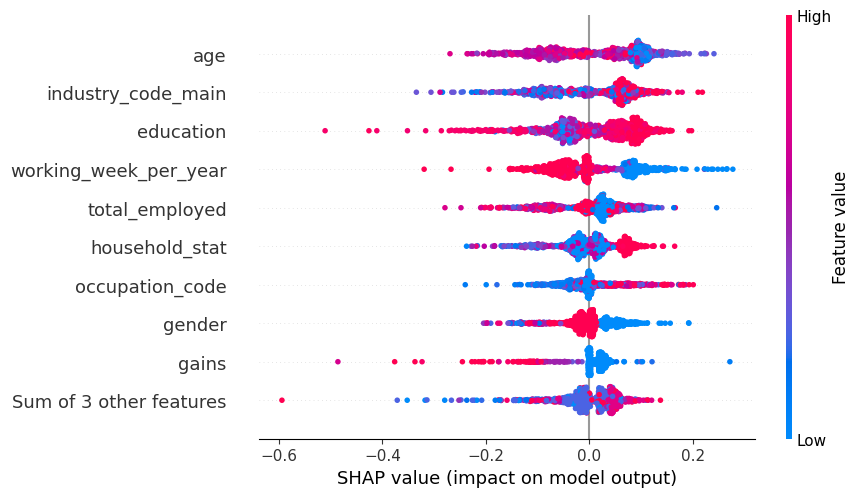

In [61]:
shap.plots.beeswarm(shap_values)

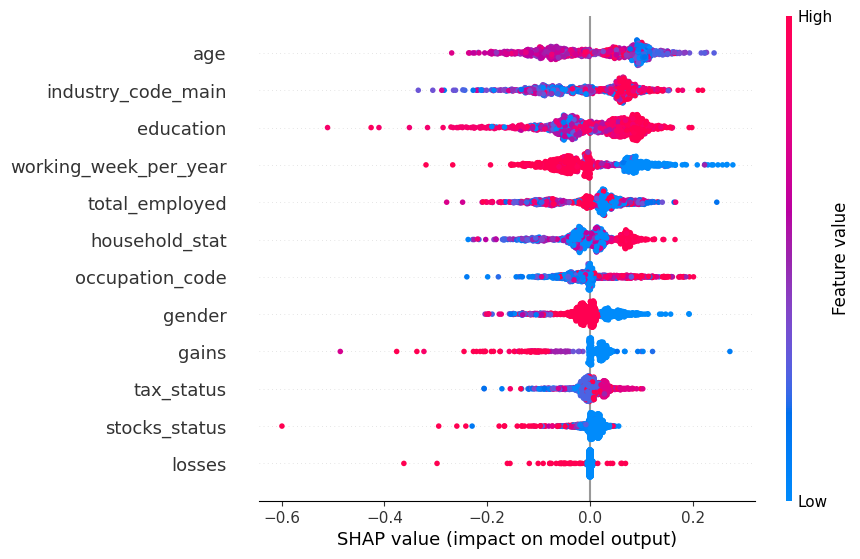

In [62]:
shap.plots.beeswarm(shap_values, max_display=20)

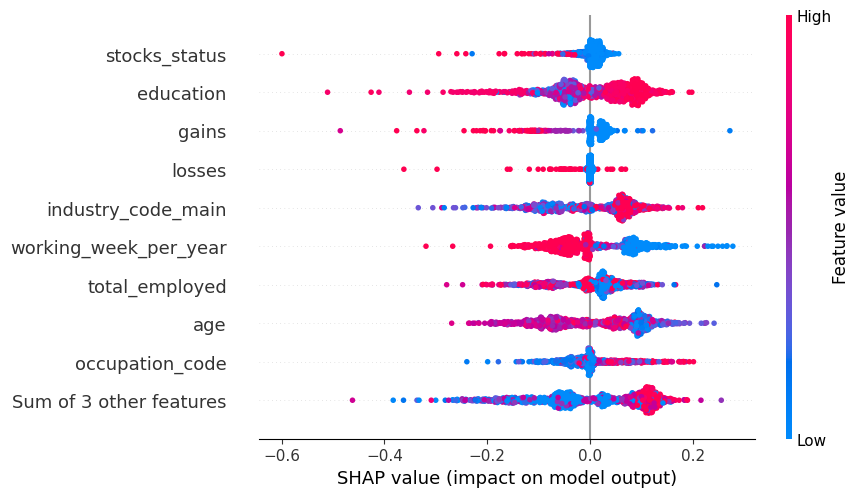

In [63]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0)) # order by max importance

#### Force Plots

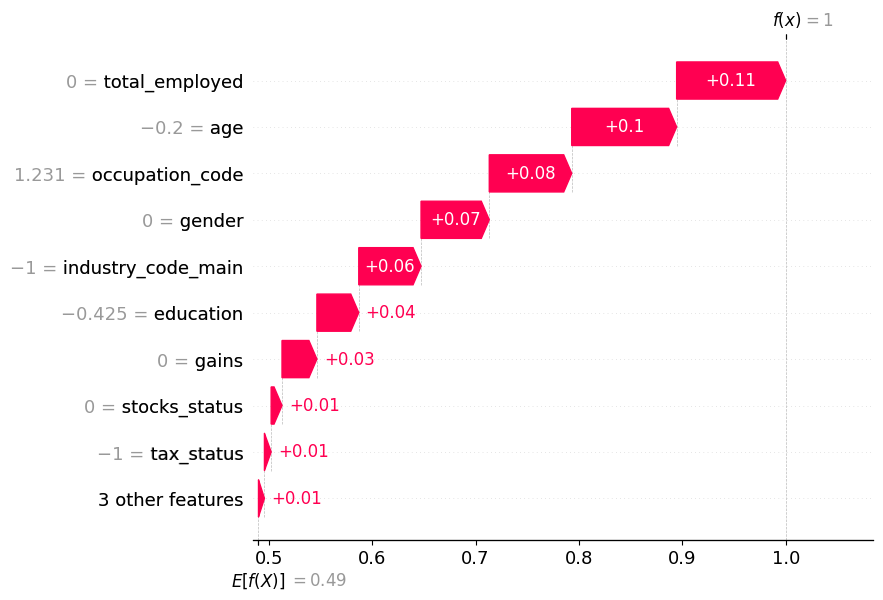

In [64]:
shap.plots.waterfall(shap_values[0])

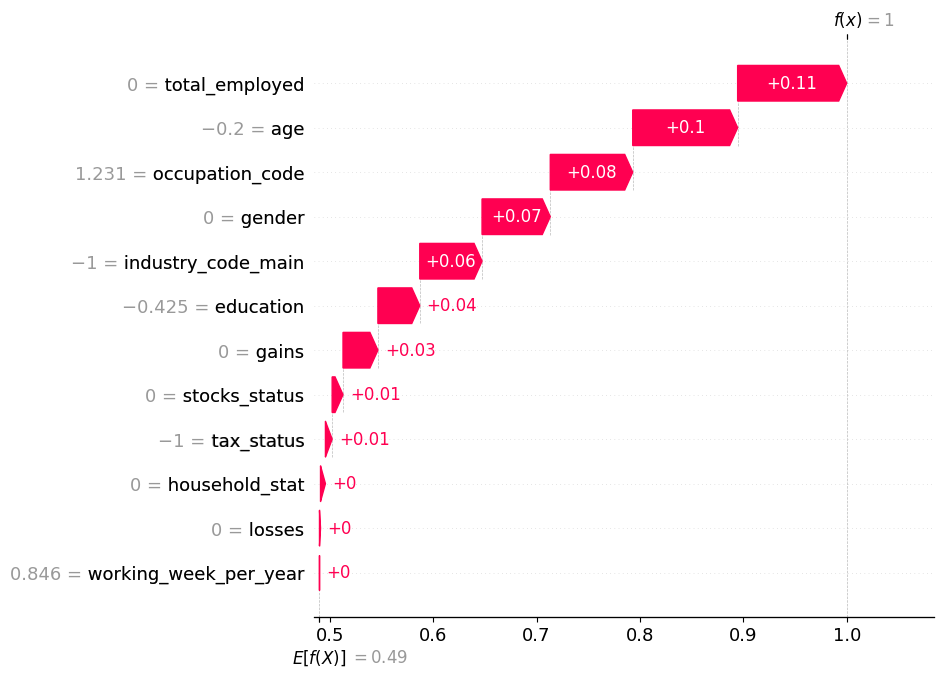

In [65]:
shap.plots.waterfall(shap_values[0], max_display=20)

In [75]:
# visualize the first prediction's explaination with default colors
shap.force_plot(shap_values[0,:], sample.iloc[0,:])

In [82]:
shap.force_plot(shap_values[:,:], sample.iloc[:,:],plot_cmap="DrDb")

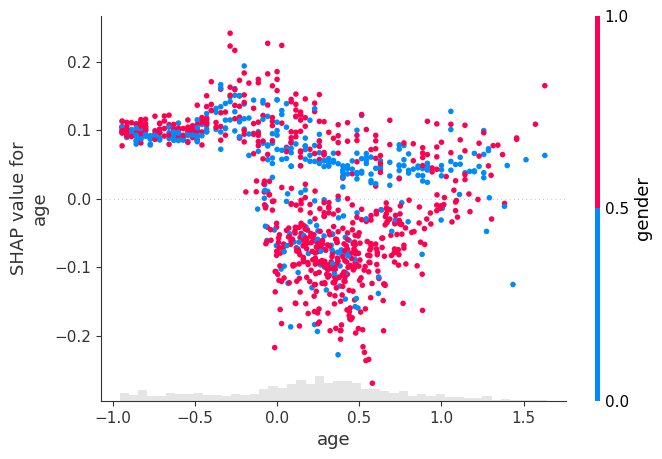

In [104]:
shap.plots.scatter(shap_values[:,"age"], color=shap_values)

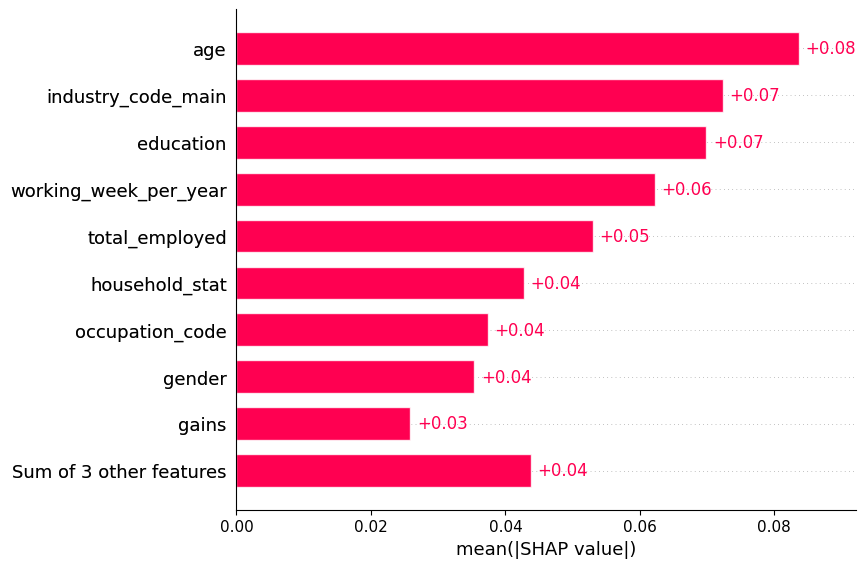

In [103]:
shap.plots.bar(shap_values)